# ResNet이란?

![resnet](./images/resnet-layers.png)

ResNet(Residual Network)는 딥러닝에서 사용되는 컨볼루션 신경망(CNN) 구조이다.

2015년 마이크로소프트 연구팀에 의해 개발되었으며, 깊은 신경망을 효율적으로 학습시키기 위해 "잔차 학습(Residual Learning)" 개념을 도입했다. 

이 아이디어는 신경망의 층을 거쳐가는 동안 신호가 약화되거나 왜곡되는 것을 방지하기 위해, 입력을 층의 출력에 직접 추가한 것이다.

# ResNet의 구조

![resnet](./images/residual.png)

ResNet의 핵심 구조는 "잔차 블록(Residual Block)"이다. 

이 블록은 입력을 블록의 출력에 더하는 스킵 연결(skip connection)을 포함한다. 

이를 통해 네트워크는 학습해야 할 목표 함수를 보다 쉽게 최적화할 수 있다. 

![resnet](./images/resnet.png)

ResNet은 깊이에 따라 여러 버전이 있으며, ResNet-34, ResNet-50, ResNet-101, ResNet-152 등이 일반적이다. 

여기서 숫자는 네트워크에 있는 층의 수를 나타낸다.

![resnet](./images/resnet-network.png)

# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm.auto import trange


C:\Users\pinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 하이퍼 파라미터

In [2]:
batch_size = 50
learning_rate = 0.0002
num_epoch = 100

# 데이터셋 구성

ResNet 학습을 위한 데이터셋 구성으로 CIFAR10를 사용한다.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define dataset
cifar10_train = datasets.CIFAR10(root="./Data/", train=True, transform=transform, target_transform=None, download=True)
cifar10_test = datasets.CIFAR10(root="./Data/", train=False, transform=transform, target_transform=None, download=True)

# define loader
train_loader = DataLoader(cifar10_train,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Basic Module

In [4]:
def conv_block_1(in_dim,out_dim, activation,stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=1, stride=stride),
        nn.BatchNorm2d(out_dim),
        activation,
    )
    return model


def conv_block_3(in_dim,out_dim, activation, stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_dim),
        activation,
    )
    return model

# Bottleneck Module

In [5]:
class BottleNeck(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,activation,down=False):
        super(BottleNeck,self).__init__()
        self.down=down
        
        # 특성지도의 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_dim,mid_dim,activation,stride=2),
              conv_block_3(mid_dim,mid_dim,activation,stride=1),
              conv_block_1(mid_dim,out_dim,activation,stride=1),
            )
            
            # 특성지도 크기 + 채널을 맞춰주는 부분
            self.downsample = nn.Conv2d(in_dim,out_dim,kernel_size=1,stride=2)
            
        # 특성지도의 크기가 그대로인 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_dim,mid_dim,activation,stride=1),
                conv_block_3(mid_dim,mid_dim,activation,stride=1),
                conv_block_1(mid_dim,out_dim,activation,stride=1),
            )
            
        # 채널을 맞춰주는 부분
        self.dim_equalizer = nn.Conv2d(in_dim,out_dim,kernel_size=1)
                  
    def forward(self,x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out

# ResNet-50 Network

In [6]:
# 50-layer
class ResNet(nn.Module):

    def __init__(self, base_dim, num_classes=10):
        super(ResNet, self).__init__()
        self.activation = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim,base_dim,base_dim*4,self.activation),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.activation),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.activation,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.activation),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.activation),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.activation),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.activation,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.activation),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.activation),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.activation),            
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.activation),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.activation),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.activation,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim*16,base_dim*8,base_dim*32,self.activation),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.activation),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.activation),
        )
        self.avgpool = nn.AvgPool2d(1,1) 
        self.fc_layer = nn.Linear(base_dim*32,num_classes)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out

# 학습

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet(base_dim=64).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
for i in trange(num_epoch):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{i}/{num_epoch}] Train Loss: {train_loss:.4f}")
    
    if i % 10 == 0:
        torch.save(model.state_dict(), f'model_epoch_{i}.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100] Train Loss: 2.0092


 10%|█         | 10/100 [13:35<2:00:50, 80.56s/it]

Epoch [10/100] Train Loss: 0.6987


 20%|██        | 20/100 [27:26<1:54:48, 86.10s/it]

Epoch [20/100] Train Loss: 0.2491


 30%|███       | 30/100 [41:02<1:33:23, 80.05s/it]

Epoch [30/100] Train Loss: 0.2013


 40%|████      | 40/100 [57:29<1:44:20, 104.35s/it]

Epoch [40/100] Train Loss: 0.1048


 50%|█████     | 50/100 [1:13:20<1:15:53, 91.07s/it] 

Epoch [50/100] Train Loss: 0.0849


 60%|██████    | 60/100 [1:28:19<59:53, 89.83s/it]  

Epoch [60/100] Train Loss: 0.0724


 70%|███████   | 70/100 [1:42:47<43:55, 87.86s/it]

Epoch [70/100] Train Loss: 0.0653


 80%|████████  | 80/100 [1:57:39<29:47, 89.39s/it]

Epoch [80/100] Train Loss: 0.0630


 90%|█████████ | 90/100 [2:12:17<14:39, 87.94s/it]

Epoch [90/100] Train Loss: 0.0605


100%|██████████| 100/100 [2:27:01<00:00, 88.22s/it]


# 결과 이미지 표시

In [ ]:
import matplotlib.pyplot as plt

# 테스트 이미지 로드 및 변환
test_image = Image.open('test.jpg')
test_image = transform(test_image).unsqueeze(0)  # 차원 추가

# 예측 수행
model.eval()
with torch.no_grad():
    output = model(test_image.to(device))

# 결과 시각화
plt.imshow(test_image.squeeze().permute(1, 2, 0))  # 차원 변경 및 시각화
plt.title("Predicted Label")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

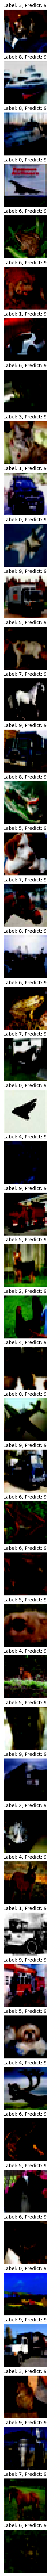

In [29]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터셋의 첫 번째 배치를 가져옴
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# 모델 예측
with torch.no_grad():
    outputs = model(images)

# 예측 결과 처리
_, predicted = torch.max(outputs, 1)

# 이미지 출력 설정
fig, axs = plt.subplots(len(images), 1, figsize=(100, 100))

for i, img in enumerate(images.cpu()):
    img = img.numpy().transpose((1, 2, 0))
    axs[i].imshow(img)
    axs[i].set_title(f'Label: {labels[i].item()}, Predict: {predicted[i].item()}', fontsize=10)
    axs[i].axis('off')

plt.show()